### Machine Learning: TF Audio Classification Data Pre-Processing Document
In this document we will read in our data set:
* read in all audio file and normalize their data
* visualize 6 random data in STFT, MFCC, Mel-Spectrogram
* Then perform feature extraction and cache as a NPY file for MFCC and Mel-Spectrogram.


In [7]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import helper

2.7.0


In [8]:
# os path to desktop
desktop_path = os.path.join(os.path.join(os.environ['USERPROFILE']), 'Desktop')

# folder directory as follows
"""

    root:
        kaggle_2018_dataset:
            train:
                wav files, and csv named catalog.csv

"""

dataset_root_dir = os.path.join(desktop_path, 'kaggle_2018_dataset')

# load the training data
dataset_train_folder = os.path.join(dataset_root_dir, 'train')
dataset_train_csv = os.path.join(dataset_train_folder, 'catalog.csv')

# load in our data_frame
data_frame = pd.read_csv(dataset_train_csv)
data_frame.drop(['license','freesound_id', 'manually_verified'], axis=1, inplace=True)
data_frame.head()


,fname,label
0,00044347.wav,Hi-hat
1,001ca53d.wav,Saxophone
2,002d256b.wav,Trumpet
3,0033e230.wav,Glockenspiel
4,00353774.wav,Cello


<AxesSubplot:>

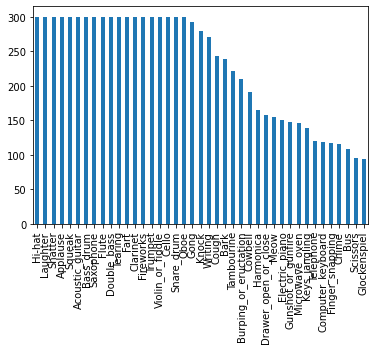

In [9]:
# visualize the label count distribution
data_frame['label'].value_counts().plot(kind='bar')

In [10]:
import os

processed_data = []
sample_rates = []

# Windowing
n_fft=2048
hop_length=512

print(f"Processing audio from: {dataset_train_folder} ... with {len(data_frame)} files\nn_fft: {n_fft}\n hop_length: {hop_length}")

length = len(data_frame)

# using librosa for every fname in our data_frame generate a mel spectrogram and save it to a numpy array
for x, row in enumerate(data_frame.iloc):
    
    # load the audio file
    y, sr = librosa.load( os.path.join( dataset_train_folder, row[0] ), sr=None)

    # normalize the audio with librosa
    normalized_y = librosa.util.normalize(y)

    # append the data to our processed_data array
    processed_data.append(normalized_y)
    sample_rates.append(sr)


print("done")

print("appending to processed_data as column 'data'")
# append the processed_data to the data frame as data
data_frame["data"] = processed_data
print("done")

print("appending to sample_rates as column 'sr'")
# append the sample_rates to the data frame as sr
data_frame["sr"] = sample_rates
print("done")


Processing audio from: C:\Users\charl\Desktop\kaggle_2018_dataset\train ... with 9473 files
n_fft: 2048
 hop_length: 512
done
appending to processed_data as column 'data'
done
appending to sample_rates as column 'sr'
done


In [11]:
data_frame.head()

,fname,label,data,sr
0,00044347.wav,Hi-hat,"[0.0, 0.0013977743, -0.00026880275, -0.0006451...",44100
1,001ca53d.wav,Saxophone,"[-0.002101777, -0.0020380868, -0.0021654672, -...",44100
2,002d256b.wav,Trumpet,"[0.0, 0.0, -0.0028860029, -0.0014430014, -0.00...",44100
3,0033e230.wav,Glockenspiel,"[0.0, 0.0011983224, 0.0046734572, -0.007908927...",44100
4,00353774.wav,Cello,"[-0.013485073, -0.012627641, -0.013407124, -0....",44100


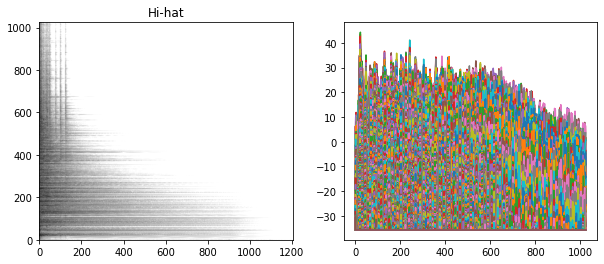

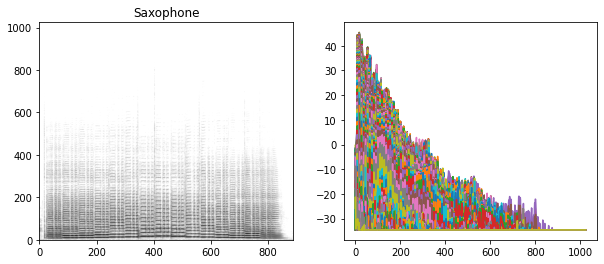

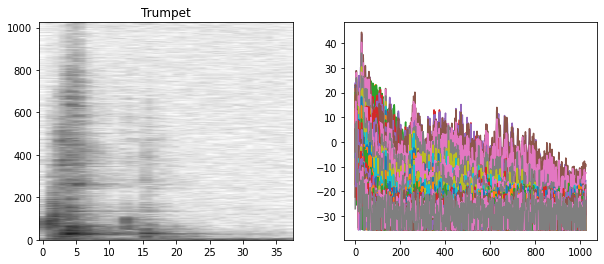

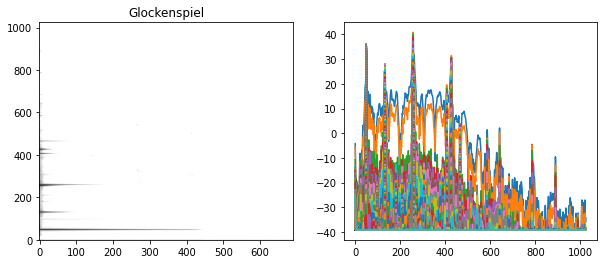

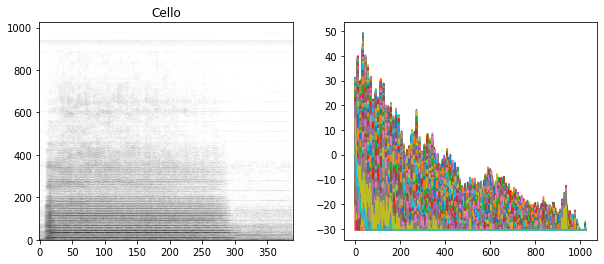

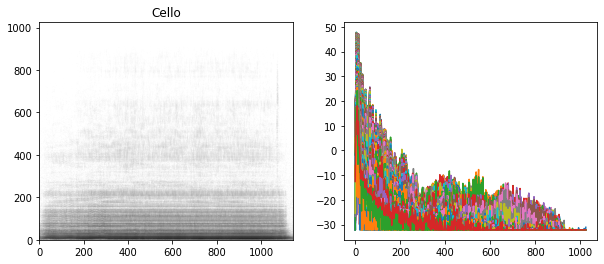

In [13]:
# display 6 random spectrograms
for i in range(6):

    # compute a short-time Fourier transform (STFT)
    D = librosa.stft(data_frame.iloc[i]['data'], n_fft=n_fft, hop_length=hop_length)
    # convert to db
    D_db = librosa.amplitude_to_db(np.abs(D))

    # display the spectrogram and data side by side
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(D_db, aspect='auto', origin='lower', cmap='gray_r')
    plt.title(data_frame.iloc[i]['label'])
    plt.subplot(1, 2, 2)
    plt.plot(D_db)
    plt.show()


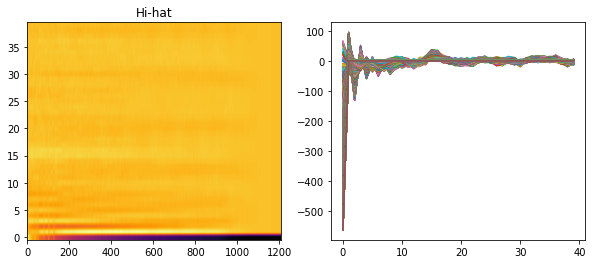

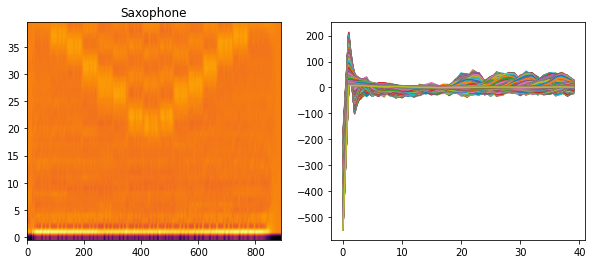

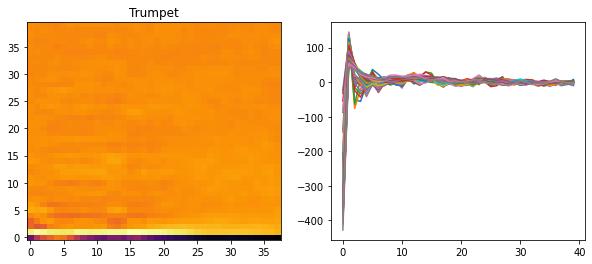

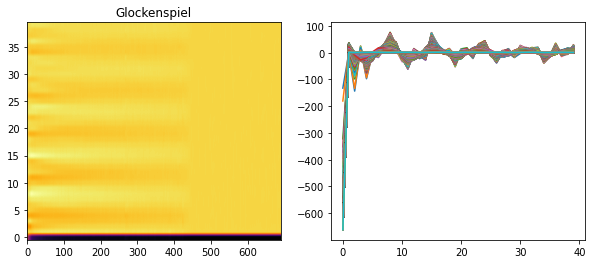

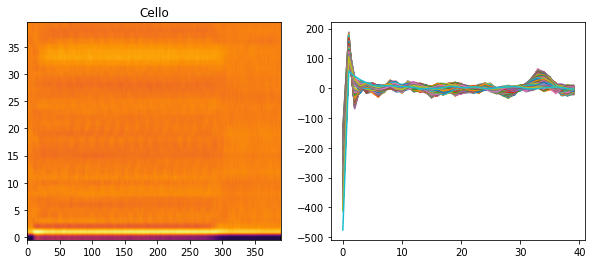

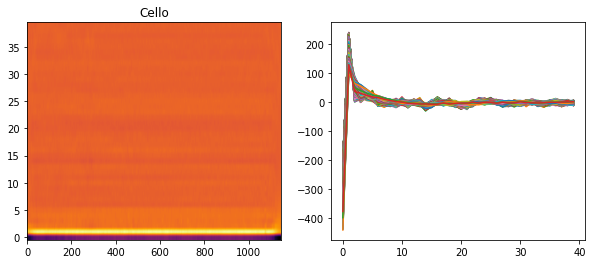

In [22]:
#import librosa.display

# display 6 random MFCCS
for i in range(6):

    mfcc = librosa.feature.mfcc(data_frame.iloc[i]['data'], sr=data_frame.iloc[i]['sr'], n_mfcc=40)

    # display the spectrogram and data side by side
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(mfcc, aspect='auto', origin='lower', cmap="inferno")
    plt.title(data_frame.iloc[i]['label'])
    plt.subplot(1, 2, 2)
    plt.plot(mfcc)
    plt.show()

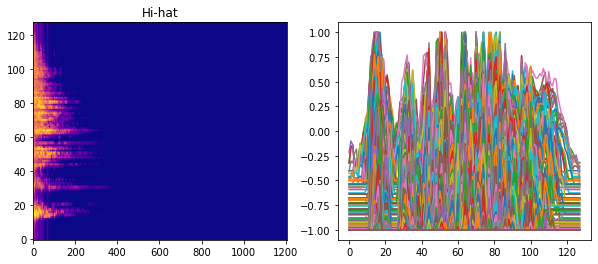

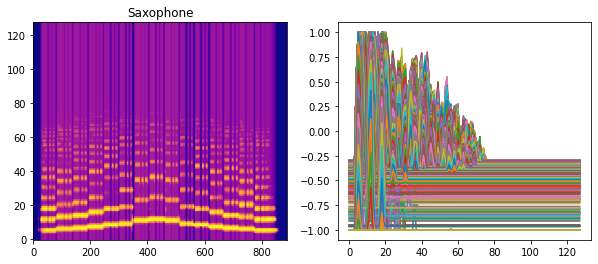

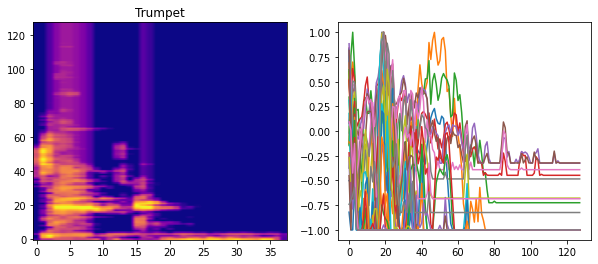

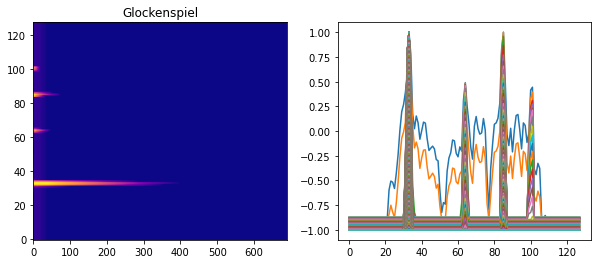

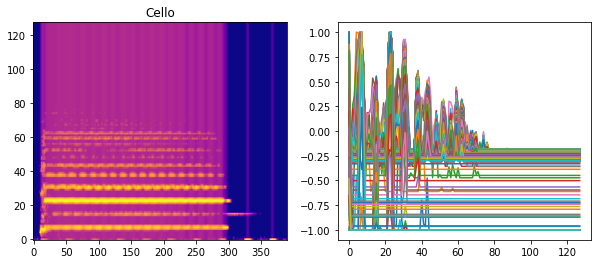

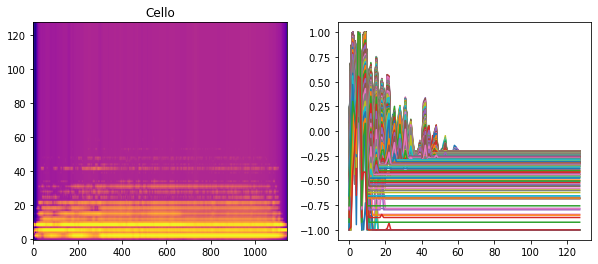

In [23]:
# create MEL-scaled filter banks spectrograms
n_mels = 128

# display 6 random mel spectrograms
for i in range(6):

    # generate a mel scaled spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(data_frame.iloc[i]['data'], sr=data_frame.iloc[i]['sr'], n_mels=n_mels)

    # convert the sound intensity to log scale
    mel_db = librosa.amplitude_to_db(np.abs(mel_spectrogram))

    # normalize the data to 0-1
    normalized_mel = librosa.util.normalize(mel_db)

    # plot the spectrogram and data side by side
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(normalized_mel, aspect='auto', origin='lower', cmap='plasma')
    plt.title(data_frame.iloc[i]['label'])
    plt.subplot(1, 2, 2)
    plt.plot(normalized_mel)
    plt.show()


### Feature Extraction of MFCCs and Mel-Spectrograms
In this segment we will now extract the features of the MFCCs and the Mel-Spectrograms

In [26]:
# Iterate through all audio files and extract MFCC
features = []
labels = []
frames_max = 0
counter = 0
total_samples = len(data_frame)
n_mfcc = 40

for index, row in data_frame.iterrows():
    class_label = row["label"]

    # Extract MFCC data
    mfcc = librosa.feature.mfcc(row['data'], sr=row['sr'], n_mfcc=40)
    
    # Save current frame count
    num_frames = mfcc.shape[1]
    
    # Add row (feature / label)
    features.append(mfcc)
    labels.append(class_label)

    # Update frames maximum
    if (num_frames > frames_max):
        frames_max = num_frames

    # Notify update every N files
    if (counter == 500):
        print("Status: {}/{}".format(index+1, total_samples))
        counter = 0

    counter += 1
    
print("Finished: {}/{}".format(index, total_samples))

Status: 501/9473
Status: 1001/9473
Status: 1501/9473
Status: 2001/9473
Status: 2501/9473
Status: 3001/9473
Status: 3501/9473
Status: 4001/9473
Status: 4501/9473
Status: 5001/9473
Status: 5501/9473
Status: 6001/9473
Status: 6501/9473
Status: 7001/9473
Status: 7501/9473
Status: 8001/9473
Status: 8501/9473
Status: 9001/9473
Finished: 9472/9473


In [28]:
# Add padding to features with less than frames than frames_max
padded_features = helper.add_padding(features, frames_max)

In [29]:
# Verify shapes
print("Raw features length: {}".format(len(features)))
print("Padded features length: {}".format(len(padded_features)))
print("Feature labels length: {}".format(len(labels)))

Raw features length: 9473
Padded features length: 9473
Feature labels length: 9473


### Save MFCC Features

In [31]:
# Convert features (X) and labels (y) to Numpy arrays
X = np.array(padded_features)
y = np.array(labels)

data_npy_folder = os.path.join(dataset_root_dir, 'data')

# Optionally save the features to disk
np.save( os.path.join(data_npy_folder, "X-mfcc" ), X)
np.save( os.path.join(data_npy_folder, "y-mfcc" ), y)

# free up memory
del X
del y
del features
del labels

In [32]:
# Iterate through all audio files and extract mel spectrograms
features = []
labels = []
frames_max = 0
counter = 0
total_samples = len(data_frame)
n_mels=40

for index, row in data_frame.iterrows():
    class_label = row["label"]

    # generate a mel scaled spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(row['data'], sr=row['sr'], n_mels=n_mels)

    # convert the sound intensity to log scale
    mel_db = librosa.amplitude_to_db(np.abs(mel_spectrogram))

    # normalize the data to 0-1
    normalized_mel = librosa.util.normalize(mel_db)

    # Save current frame count
    num_frames = normalized_mel.shape[1]
    
    # Add row (feature / label)
    features.append(normalized_mel)
    labels.append(class_label)

    # Update frames maximum
    if (num_frames > frames_max):
        frames_max = num_frames

    # Notify update every N files
    if (counter == 500):
        print("Status: {}/{}".format(index+1, total_samples))
        counter = 0

    counter += 1
    
print("Finished: {}/{}".format(index, total_samples))

Status: 501/9473
Status: 1001/9473
Status: 1501/9473
Status: 2001/9473
Status: 2501/9473
Status: 3001/9473
Status: 3501/9473
Status: 4001/9473
Status: 4501/9473
Status: 5001/9473
Status: 5501/9473
Status: 6001/9473
Status: 6501/9473
Status: 7001/9473
Status: 7501/9473
Status: 8001/9473
Status: 8501/9473
Status: 9001/9473
Finished: 9472/9473


In [33]:
# Add padding to features with less than frames than frames_max
padded_features = helper.add_padding(features, frames_max)

In [34]:
# Verify shapes
print("Raw features length: {}".format(len(features)))
print("Padded features length: {}".format(len(padded_features)))
print("Feature labels length: {}".format(len(labels)))

Raw features length: 9473
Padded features length: 9473
Feature labels length: 9473


In [35]:
# Convert features (X) and labels (y) to Numpy arrays
X = np.array(padded_features)
y = np.array(labels)

data_npy_folder = os.path.join(dataset_root_dir, 'data')

# Optionally save the features to disk
np.save( os.path.join(data_npy_folder, "X-mel-spec" ), X)
np.save( os.path.join(data_npy_folder, "y-mel-spec" ), y)

# free up memory
del X
del y
del features
del labels

### radacted

In [178]:
# create training and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=42)
# output the length of x data vs our x train data and x test data
# these x_train will be used in training only, and x_test will be used to test the neural network
len(data_frame["data"]), len(x_train), len(x_test), len(y_train), len(y_test)

(9473, 7578, 1895, 7578, 1895)

### Create the CNN model
In this section we are going to create the TF CNN model

In [179]:
# get the shape of the first spectrogram
spectrogram_shape = data_frame.iloc[0]['data'].shape

# get the length of labels in our data_frame
label_length = len(data_frame['label'].unique())

print(spectrogram_shape, label_length)

# set the random seed
tf.random.set_seed(42)


IMAGE_HEIGHT = spectrogram_shape[0]
IMAGE_WIDTH = spectrogram_shape[1]
N_CHANNELS = 2
N_CLASSES = label_length

# Create CNN model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, N_CHANNELS)))
model.add(tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(N_CLASSES, activation='softmax'))


(128, 1206) 41


In [180]:
# 2. compile the model
model.compile(
    loss = tf.keras.losses.mae, # mean absolute error predicted vs observed
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), # stochastic gradient descent (lr=1e-3)
    metrics=['mae'] # mean absolute error
)

In [181]:
# early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='mae',
    patience=3
)

# 3. train the model
history = model.fit(
    x_train,
    y_train,
    epochs=1000,
    verbose=1,
    callbacks=[early_stopping_callback],
    validation_data=(x_test, y_test)
)


# x_train = [ x['data'] for x in data_frame.iloc ]
# # x_train = data_frame.iloc[:int(len(data_frame)*0.8)]['data']
# # # convert x train to numpy array
# # x_train = np.array(x_train)
# y_train = data_frame['label']
# # x_train
# history = model.fit(x_train, y_train, epochs=20)#, validation_data=(X_val, y_val))

ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'numpy.ndarray'>"}), (<class 'list'> containing values of types {"<class 'str'>"})

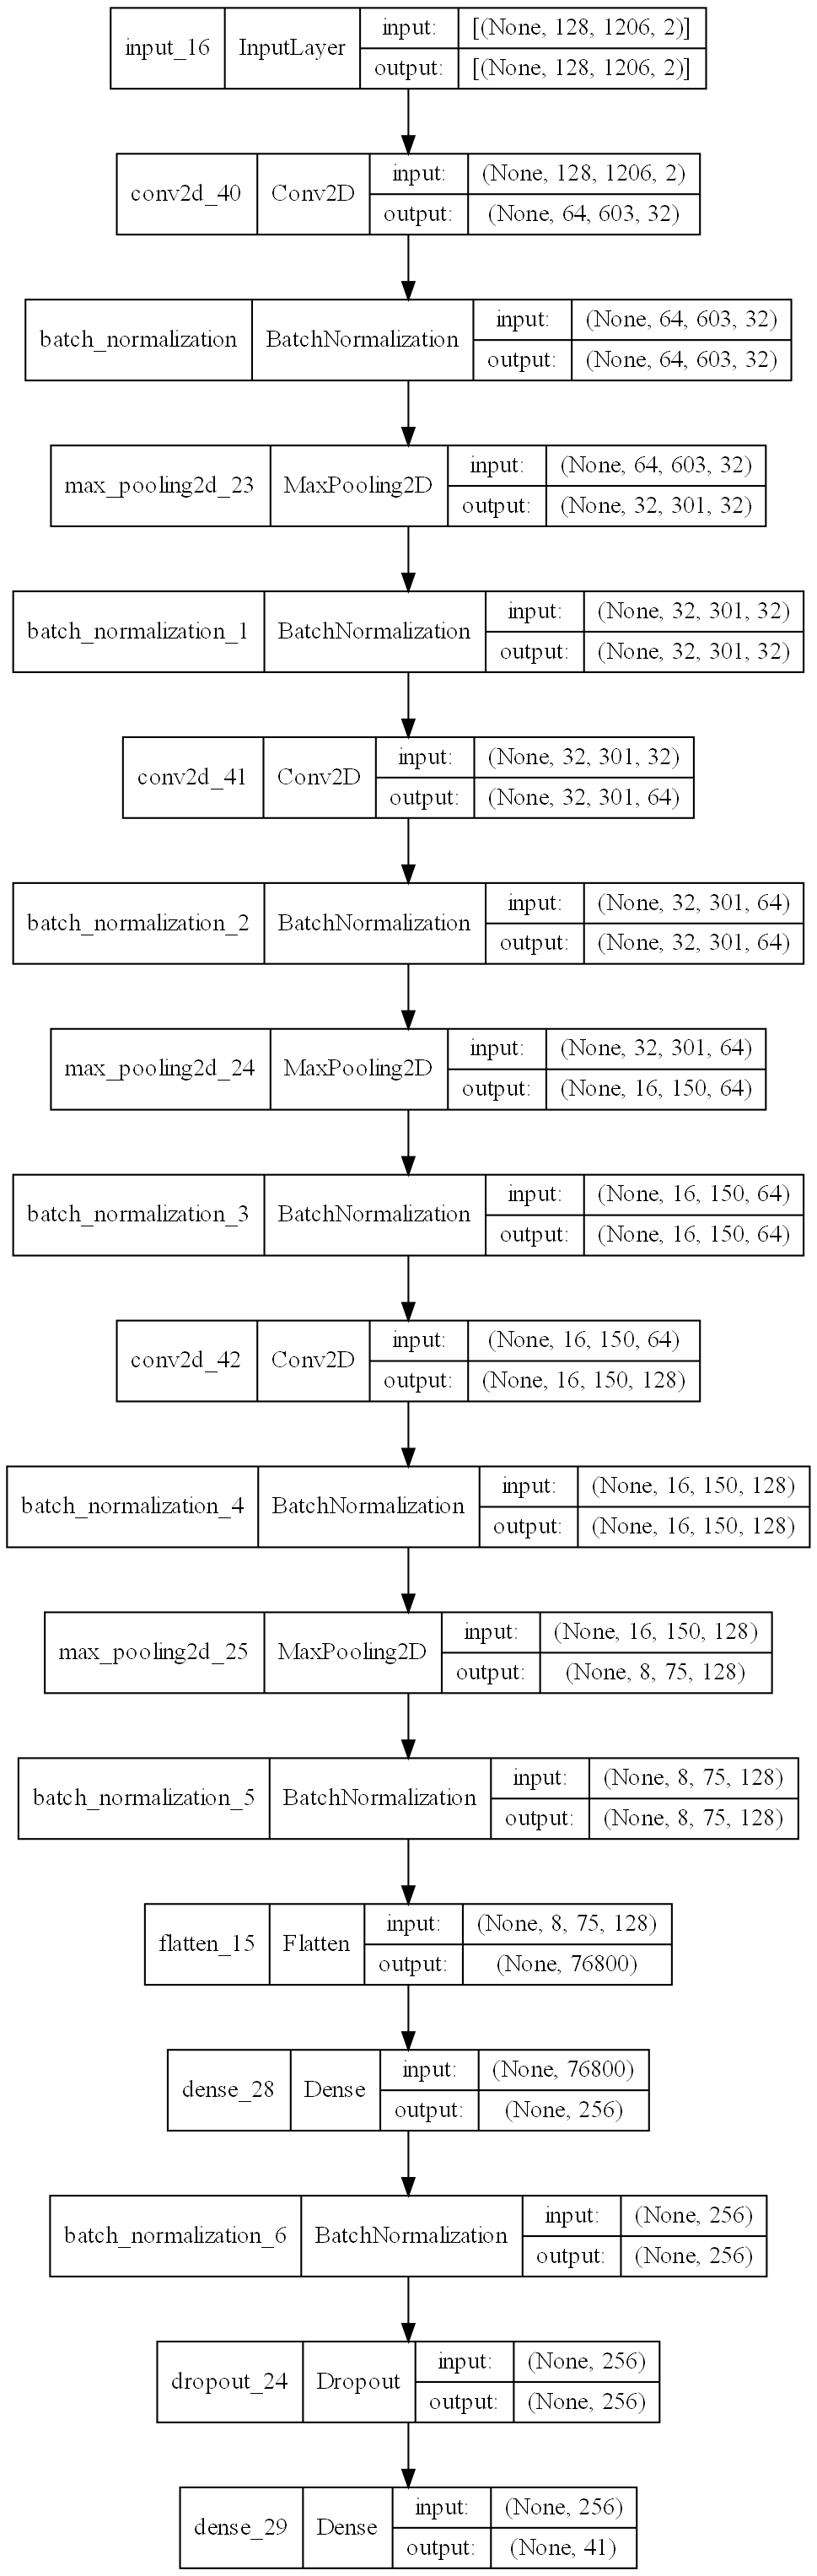

In [157]:
plot_model(model, show_shapes=True, expand_nested=True, dpi=150)

In [1]:
modelplot = ModelPlot(model=model, grid=True, connection=True, linewidth=0.1)
modelplot.show()

NameError: name 'ModelPlot' is not defined

In [ ]:

# CNNmodel = tf.keras.models.Sequential()
# CNNmodel.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 1206, 1)))
# CNNmodel.add(tf.keras.layers.MaxPooling2D((2, 2)))
# CNNmodel.add(tf.keras.layers.Flatten())
# CNNmodel.add(tf.keras.layers.Dense(32, activation='relu'))
# CNNmodel.add(tf.keras.layers.Dense(24, activation='softmax'))

# # Instantiate the `tf.keras.layers.Normalization` layer.
# norm_layer = tf.keras.layers.Normalization()
# # Fit the state of the layer to the spectrograms
# # with `Normalization.adapt`.
# norm_layer.adapt(data=data_frame.iloc[0]['data'])

# # construct our model
# CNNmodel = tf.keras.Sequential(
#     [
#         tf.keras.layers.Input(shape=(128, 1206, 3)), # set the input shape to the shape of the spectrogram
#         tf.keras.layers.Resizing(32, 32), # Downsample the input. ?? why????
#         norm_layer, # Normalize the input. why????
#         tf.keras.layers.Conv2D(32, 3, activation='relu'),
#         tf.keras.layers.Conv2D(64, 3, activation='relu'),
#         tf.keras.layers.MaxPooling2D(),
#         tf.keras.layers.Dropout(0.25),
#         tf.keras.layers.Flatten(),
#         tf.keras.layers.Dense(128, activation='relu'),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.Dense(label_length),
#         # #tf.keras.layers.Normalization(axis=-1, input_shape=spectrogram_shape), # Normalize the input.
#         # tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
#         # tf.keras.layers.MaxPooling2D((2, 2)),
#         # tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#         # tf.keras.layers.MaxPooling2D((2, 2)),
#         # tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     ]    
# ) 


In [ ]:
# look at this because it shows good examples of normalizing audio data
https://github.com/GorillaBus/urban-audio-classifier/blob/master/2-pre-processing.ipynb